In [8]:
!pip install tensorflow==2.17.0



# **Импорт библиотек**

In [1]:
import os
import numpy as np
import pydicom
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import Sequence
from medpy.io import load
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
tf.test.is_built_with_cuda()

False

# **Модель на архетиктуре Unet**

In [2]:
# Установка формата данных
K.set_image_data_format('channels_last')

# Метрики
def dice_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    union = K.sum(y_true_f + y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)

# Модель U-Net
def unet_1(img_channels, image_rows, image_cols, neurons=16):
    inputs = Input((image_rows, image_cols, img_channels))
    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    up6 = Dropout(0.5)(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    up7 = Dropout(0.5)(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    up8 = Dropout(0.5)(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    up9 = Dropout(0.5)(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Dropout(0.5)(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef])
    return model

# **Загрузка данных**

In [3]:
image_size = (128, 128)

def load_dicom_image(image_path):
    dicom_data = pydicom.dcmread(image_path)
    image = dicom_data.pixel_array
    image = cv2.resize(image, image_size)
    image = np.expand_dims(image, axis=-1)  # Добавляем размерность канала
    image = image / 255.0  # Нормализация [0, 1]
    return image

# Функция для загрузки масок в формате PNG
def load_mask(mask_path):
    mask = load_img(mask_path, color_mode='grayscale', target_size=image_size)
    mask = img_to_array(mask)  # Преобразуем в numpy массив
    mask = mask / 255.0  # Нормализация [0, 1]
    return mask

# **Генератор данных**

In [4]:

path = r'D:\projects\liver-segmentation-web-service\liver-segmentation-model\sets\Train_Sets\CT\\'

class DatasetLoader(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.current_index = 0

    def __len__(self):
        """ Возвращает количество батчей в эпохе. """
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """
        Возвращает батч изображений и масок.

        :param index: индекс батча
        :return: изображение и маска
        """
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.image_paths))
        batch_image_paths = self.image_paths[start:end]
        batch_mask_paths = self.mask_paths[start:end]

        images = [load_dicom_image(img_path) for img_path in batch_image_paths]
        masks = [load_mask(mask_path) for mask_path in batch_mask_paths]

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        """ Перемешиваем данные в конце каждой эпохи. """
        temp = list(zip(self.image_paths, self.mask_paths))
        np.random.shuffle(temp)
        self.image_paths, self.mask_paths = zip(*temp)
        

def get_all_paths(path):
    image_paths = []
    mask_paths = []

    for i in range(1, 21):  # Цикл по папкам от 1 до 20
        dicom_folder = os.path.join(path, str(i), 'DICOM_anon')
        mask_folder = os.path.join(path, str(i), 'Ground')

        dicom_files = sorted(os.listdir(dicom_folder))
        mask_files = sorted(os.listdir(mask_folder))

        for dicom_file, mask_file in zip(dicom_files, mask_files):
            dicom_path = os.path.join(dicom_folder, dicom_file)
            mask_path = os.path.join(mask_folder, mask_file)

            image_paths.append(dicom_path)
            mask_paths.append(mask_path)

    return image_paths, mask_paths

# Получаем все пути к изображениям и маскам
image_paths, mask_paths = get_all_paths(path)

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Создаем загрузчики данных
train_loader = DatasetLoader(train_image_paths, train_mask_paths, batch_size=16)
val_loader = DatasetLoader(val_image_paths, val_mask_paths, batch_size=16)





# **Проверка изображений**

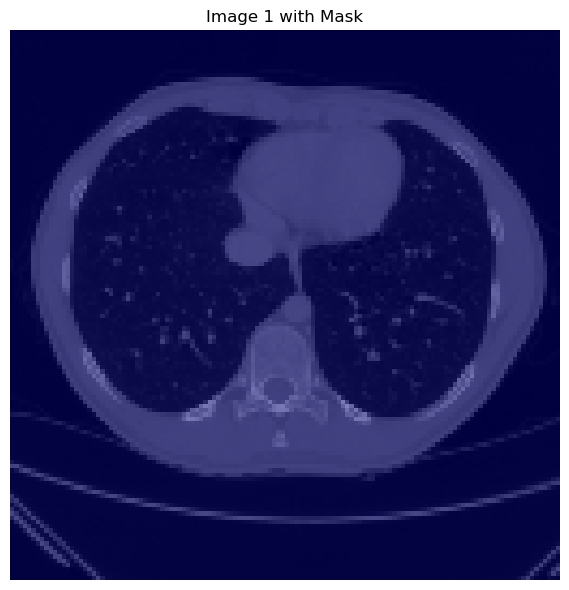

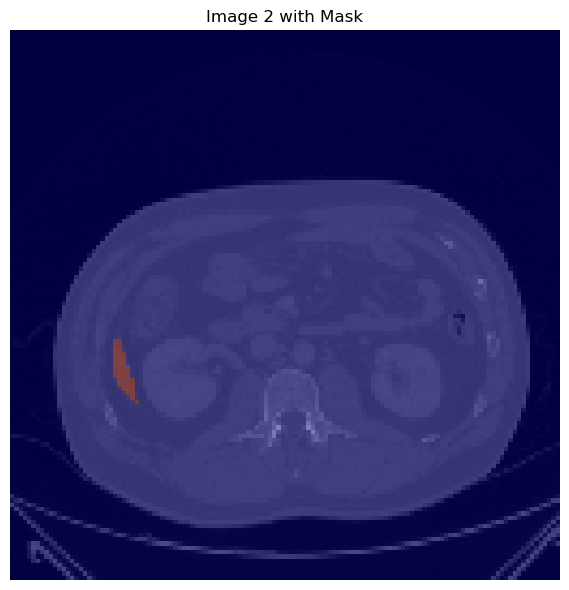

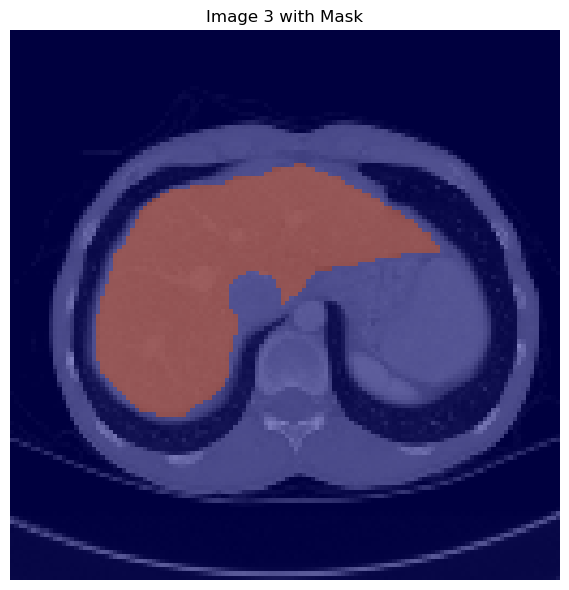

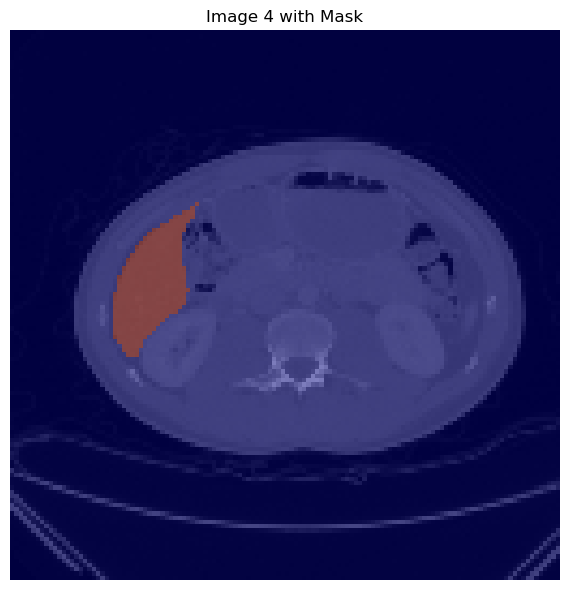

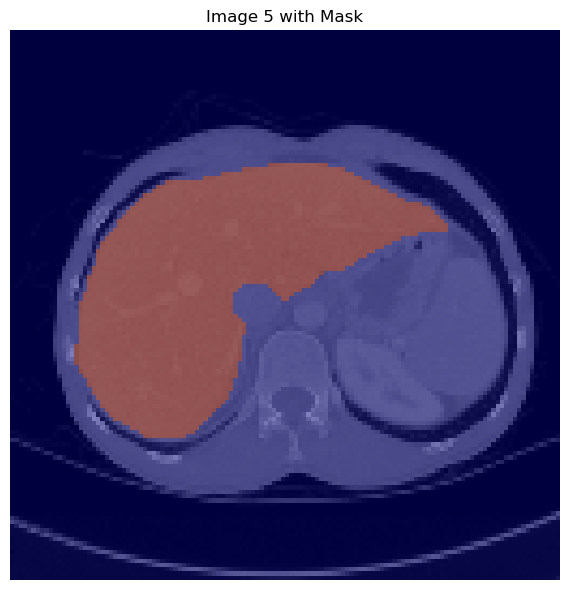

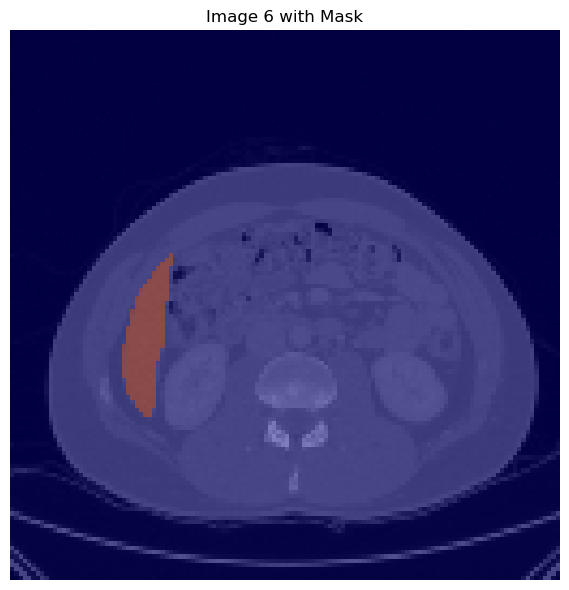

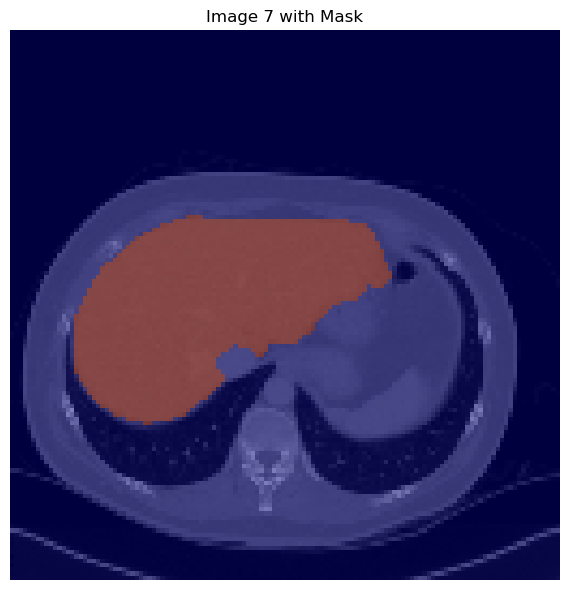

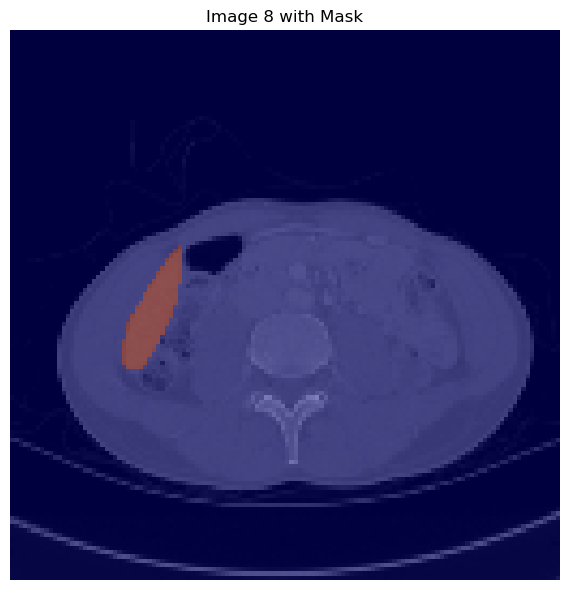

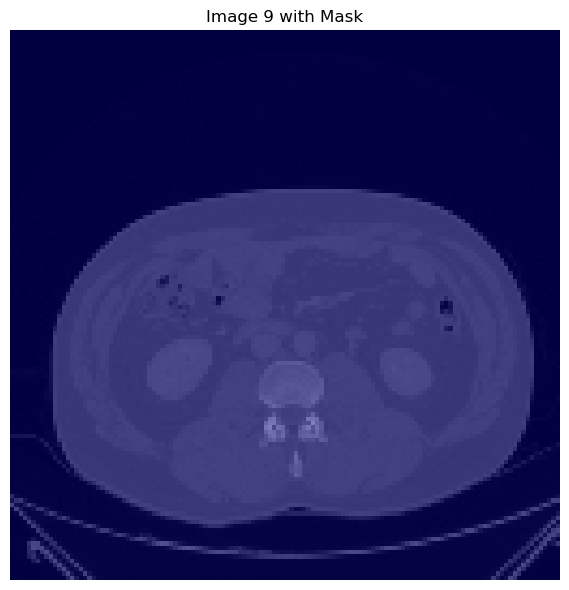

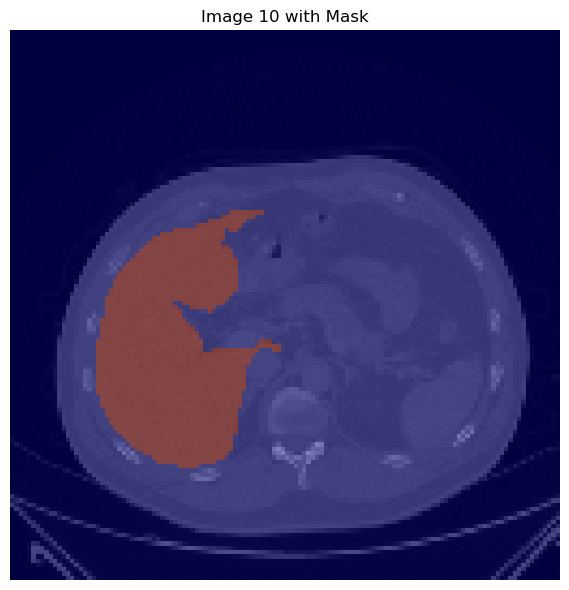

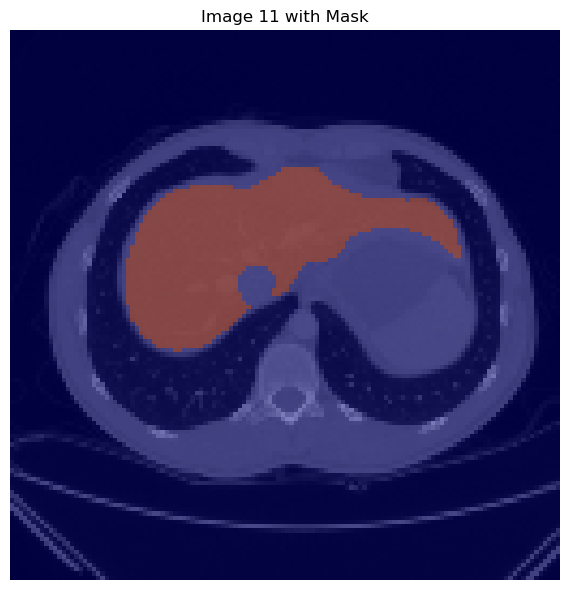

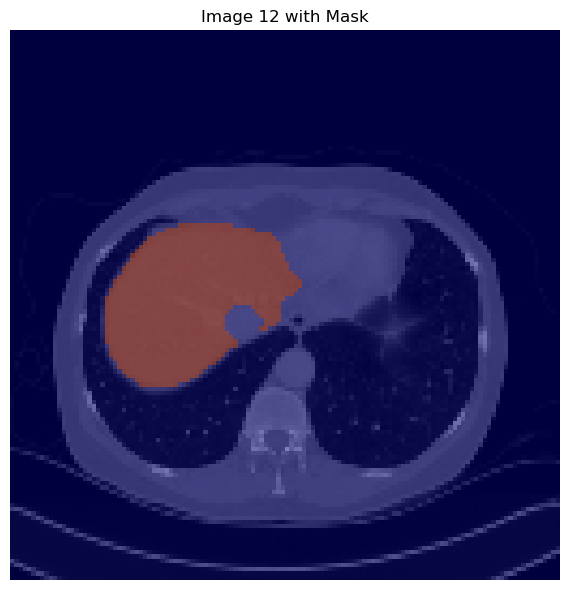

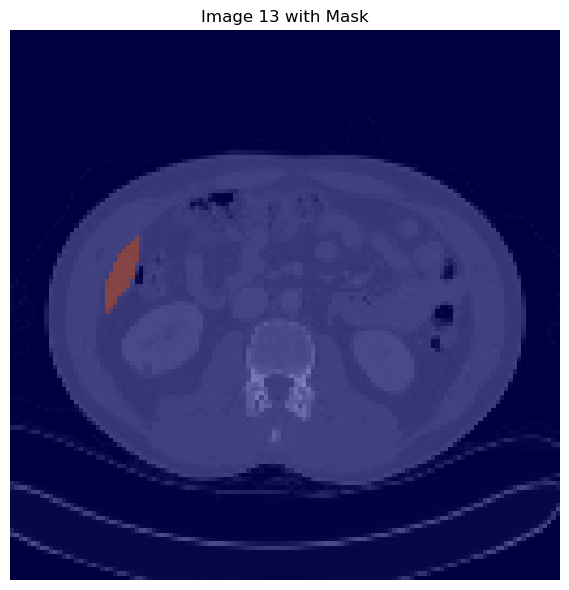

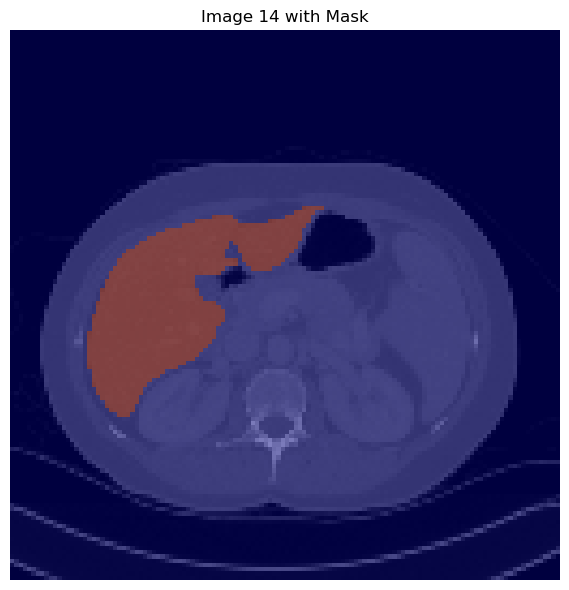

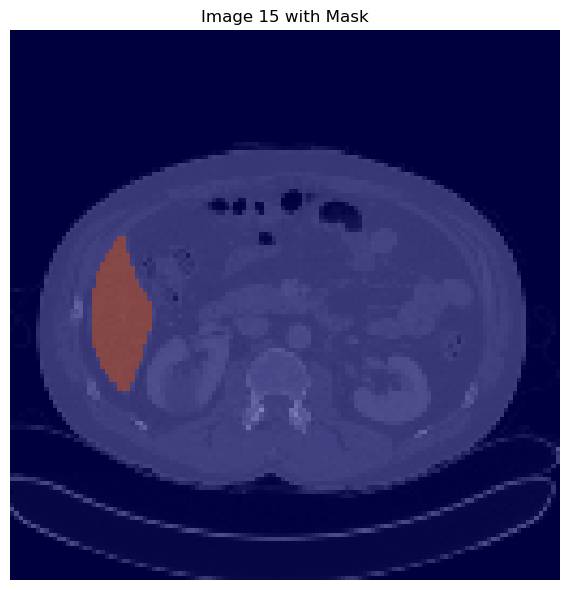

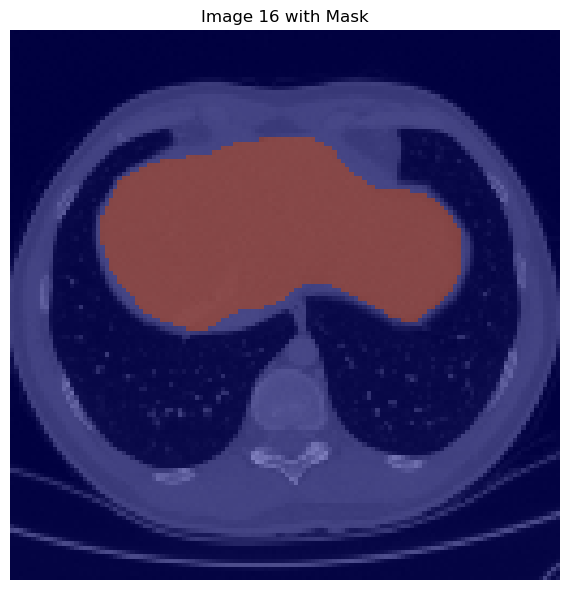

In [6]:
def display_batch_with_overlay(images, masks):
    """
    Функция для отображения одного батча изображений с наложением маски.
    
    :param images: список изображений в батче
    :param masks: список масок в батче
    """
    batch_size = len(images)
    
    # Отображаем первое изображение с маской
    for i in range(batch_size):
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
        # Отображаем изображение КТ
        ax.imshow(images[i], cmap='gray')
        
        # Наложим маску на изображение с прозрачностью
        ax.imshow(masks[i], cmap='jet', alpha=0.5)  # alpha=0.5 добавляет полупрозрачность маски
        
        ax.set_title(f"Image {i+1} with Mask")
        ax.axis('off')

        plt.tight_layout()
        plt.show()

# Пример использования
def visualize_train_batch_with_overlay(loader):
    """
    Визуализация одного батча из загрузчика данных с наложением маски на изображение КТ.
    
    :param loader: экземпляр DatasetLoader
    """
    # Получаем один батч
    images, masks = next(iter(loader))
    
    # Отображаем батч с наложением масок на изображения
    display_batch_with_overlay(images, masks)

# Визуализируем один батч из тренировочного набора данных с наложением маски
visualize_train_batch_with_overlay(train_loader)

# **Тренировка модели**

In [7]:

model = unet_1(img_channels=1, image_rows=128, image_cols=128)

# Колбэки
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss', mode='min')
reduce_lr_cb = ReduceLROnPlateau(factor=0.1, patience=5, verbose=1, monitor='val_loss', mode='min')
tensorboard_cb = TensorBoard(log_dir='./logs')

# Обучение модели
history = model.fit(
    train_loader,  # Тренировочный набор данных
    epochs=50,
    validation_data=val_loader,  # Валидационный набор данных
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb]
)



d:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


d:\anaconda\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 159s 988ms/step - dice_coef: 0.5610 - loss: 0.4392 - val_dice_coef: 0.0770 - val_loss: 0.9229 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 66s 455ms/step - dice_coef: 0.8604 - loss: 0.1396 - val_dice_coef: 4.1088e-22 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 66s 455ms/step - dice_coef: 0.8797 - loss: 0.1203 - val_dice_coef: 0.7297 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 66s 461ms/step - dice_coef: 0.8954 - loss: 0.1049 - val_dice_coef: 0.4868 - val_loss: 0.5135 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 67s 463ms/step - dice_coef: 0.9000 - loss: 0.1000 - val_dice_coef: 0.9232 - val_loss: 0.0768 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 472ms/step - dice_coef: 0.9307 - loss: 0.0693 - val_dice_coef: 0.9400 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 67s 467ms/step - dice_co

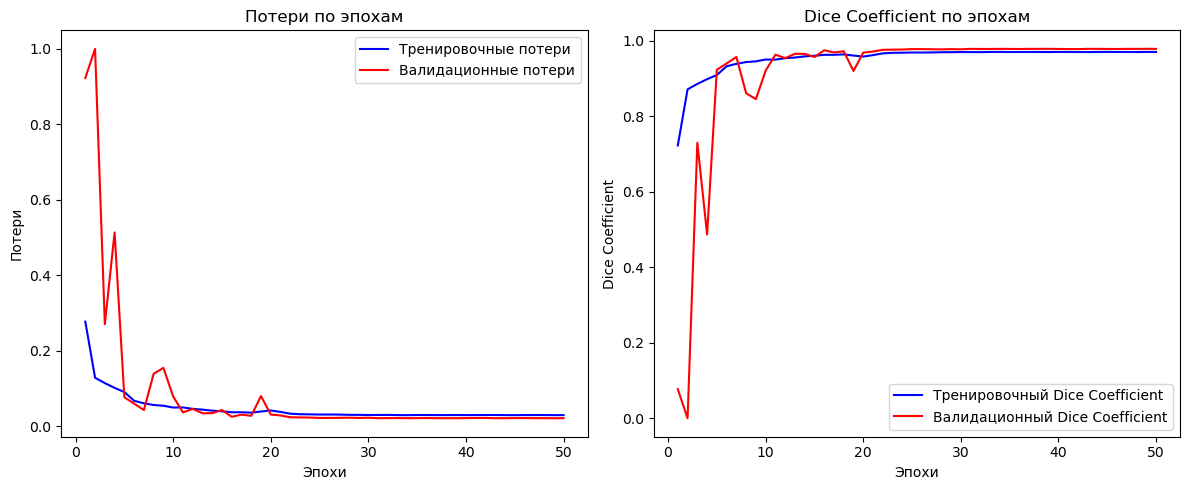

In [8]:
def plot_training_history(history):
    """
    Функция для построения графиков потерь и метрик по эпохам.
    
    :param history: Объект history, возвращаемый при тренировке модели Keras.
    """
    # Извлекаем потери и метрики из history
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)
    
    # Если используется метрика dice_coef
    dice_coef = history.history.get('dice_coef', None)
    val_dice_coef = history.history.get('val_dice_coef', None)

    # Если используется метрика jaccard_coef
    jaccard_coef = history.history.get('jaccard_coef', None)
    val_jaccard_coef = history.history.get('val_jaccard_coef', None)
    
    epochs = range(1, len(loss) + 1)

    # Построение графика потерь
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Тренировочные потери')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 'r', label='Валидационные потери')
    plt.title('Потери по эпохам')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()

    # Построение графика метрики (например, dice_coef)
    if dice_coef is not None:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, dice_coef, 'b', label='Тренировочный Dice Coefficient')
        if val_dice_coef is not None:
            plt.plot(epochs, val_dice_coef, 'r', label='Валидационный Dice Coefficient')
        plt.title('Dice Coefficient по эпохам')
        plt.xlabel('Эпохи')
        plt.ylabel('Dice Coefficient')
        plt.legend()

    # Если используется Jaccard, то добавляем график метрики Jaccard
    if jaccard_coef is not None:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, jaccard_coef, 'g', label='Тренировочный Jaccard Coefficient')
        if val_jaccard_coef is not None:
            plt.plot(epochs, val_jaccard_coef, 'm', label='Валидационный Jaccard Coefficient')
        plt.title('Jaccard Coefficient по эпохам')
        plt.xlabel('Эпохи')
        plt.ylabel('Jaccard Coefficient')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# **Прогон тестовых изображений, предикт модели**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


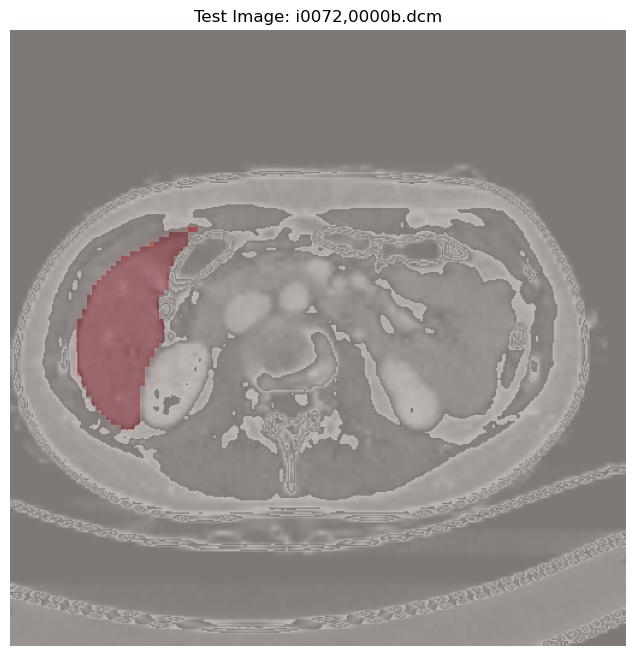

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


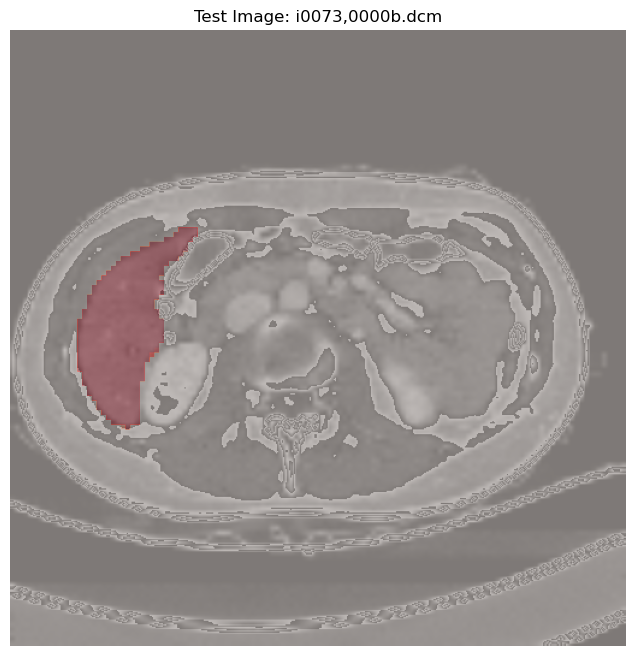

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


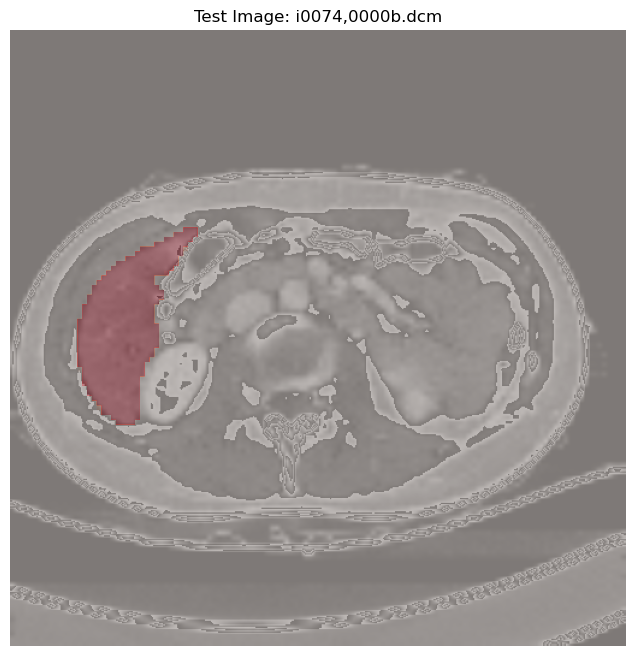

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


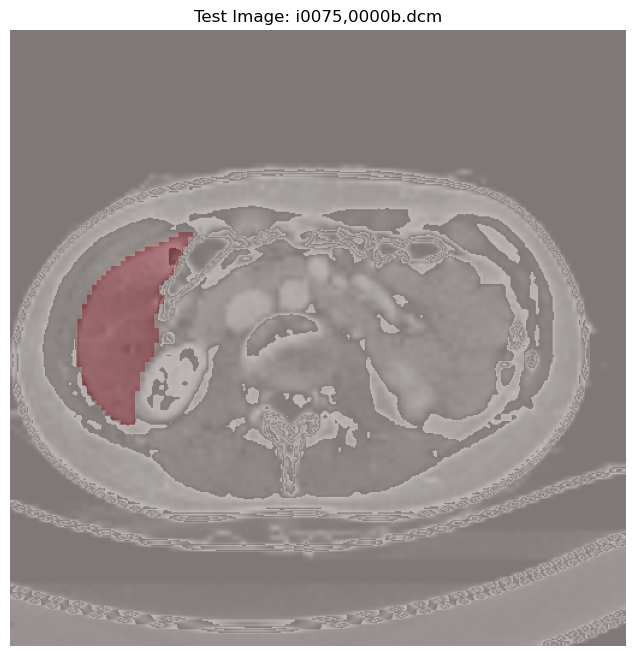

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


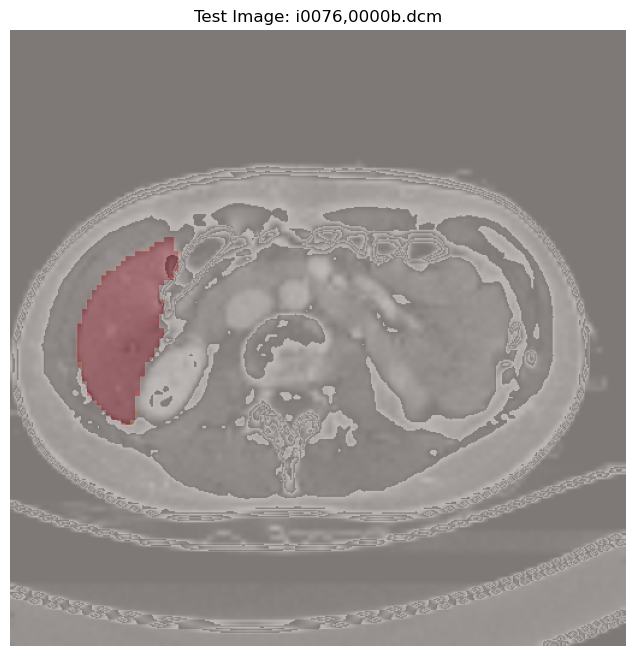

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


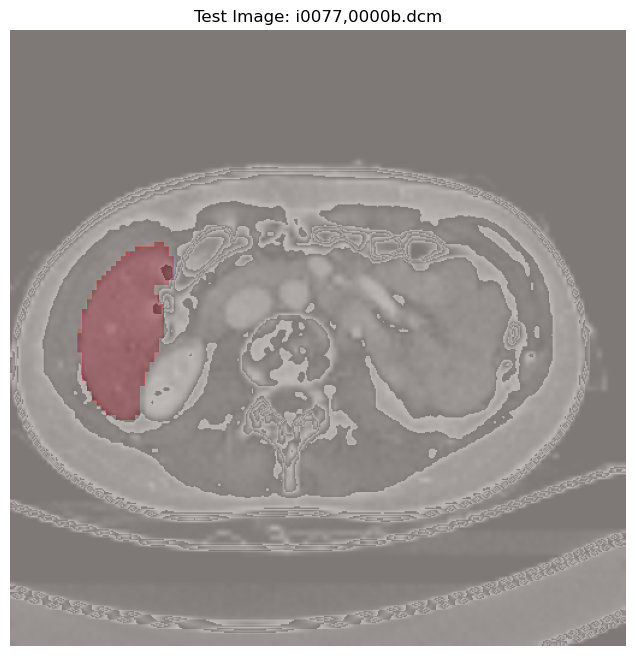

In [11]:
def load_and_predict_dicom_image(file_path, model, image_size=(128, 128)):
    dicom_data = pydicom.dcmread(file_path)
    image = dicom_data.pixel_array
    image = cv2.resize(image, image_size)  # Ресайз на 128x128
    image = np.expand_dims(image, axis=-1)  # Добавляем размерность канала (1, 128, 128, 1)
    image = image / 255.0  # Нормализация изображения

    image = np.expand_dims(image, axis=0)  # Добавляем batch dimension (1, 128, 128, 1)
    
    # Предсказание маски моделью
    predicted_mask = model.predict(image)[0]
    
    # Восстановление размера изображения и предсказанной маски до оригинала (512x512)
    image_original = cv2.resize(image.squeeze(), (512, 512))  # Восстанавливаем изображение до оригинала
    predicted_mask_original = cv2.resize(predicted_mask, (512, 512), interpolation=cv2.INTER_NEAREST)  # Восстанавливаем маску

    return image_original, predicted_mask_original

# Функция для наложения маски на изображение
def overlay_mask_on_image(image, mask, alpha=0.5):
    """
    Накладывает маску на изображение с прозрачностью (alpha).
    """
    # Если изображение одноцветное (1 канал), добавляем 2 дополнительные размерности для RGB
    if image.ndim == 2:  # Если у изображения 2 измерения (128, 128)
        image = np.repeat(image[:, :, np.newaxis], 3, axis=-1)  # Делаем 3 канала (128, 128, 3)
    
    # Приводим изображение к формату uint8
    image = (image * 255).astype(np.uint8)

    # Маска будет серого цвета и преобразуем в формат (512, 512, 3)
    mask_colored = np.repeat(mask[:, :, np.newaxis], 3, axis=-1)
    mask_colored = (mask_colored * 255).astype(np.uint8)  # Преобразуем маску в цветной формат (0-255)

    # Совмещение изображения и маски
    overlayed_image = cv2.addWeighted(image, 1 - alpha, mask_colored, alpha, 0)

    return overlayed_image

# Функция для отображения изображения с наложенной маской
def display_image_with_mask_overlay(image, mask, title=""):
    """
    Отображает изображение с наложенной маской.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.5)  # Маска наложена с прозрачностью
    plt.title(title)
    plt.axis('off')
    plt.show()

# Путь к тестовому набору данных
test_set_path = r'D:\projects\liver-segmentation-web-service\liver-segmentation-model\sets\Test_Sets\CT\\'

from keras.models import load_model

# Загрузка модели
model = load_model(r'D:\projects\liver-segmentation-web-service\liver-segmentation-model\best_model.keras', 
                   custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})


# Получаем все пути к изображениям в тестовом наборе
def get_test_paths(path):
    test_image_paths = []
    for i in range(1, 20):  # Папки от 1 до 20
        dicom_folder = os.path.join(path, str(i), 'DICOM_anon')
        dicom_files = sorted(os.listdir(dicom_folder))

        for dicom_file in dicom_files:
            dicom_path = os.path.join(dicom_folder, dicom_file)
            test_image_paths.append(dicom_path)

    return test_image_paths

# Получаем пути к тестовым изображениям
test_image_paths = get_test_paths(test_set_path)

# Загружаем модель
# model = load_model(r'D:\projects\liver-segmentation-web-service\liver-segmentation-model\best_model.keras')

# Прогоняем изображения через модель и визуализируем
for img_path in test_image_paths[150:156]:  # Прогоняем первые 5 изображений
    # Загружаем изображение и предсказываем маску
    image, predicted_mask = load_and_predict_dicom_image(img_path, model)

    # Наложение маски на изображение
    overlayed_image = overlay_mask_on_image(image, predicted_mask, alpha=0.5)

    # Визуализация изображения с наложенной маской
    display_image_with_mask_overlay(overlayed_image, predicted_mask, title=f"Test Image: {os.path.basename(img_path)}")